In [ ]:
!pip install torch transformers tokenizers

In [ ]:
import os, json
from huggingface_hub import snapshot_download
from datasets import Dataset

# Snapshot
local_dir = snapshot_download("roneneldan/TinyStories", repo_type="dataset")

# Path to the big train TXT
train_txt = os.path.join(local_dir, "TinyStories-train.txt")

#  Read & parse just ~10% into a list
max_examples = 211_972
examples = []
with open(train_txt, "r", encoding="utf-8") as f:
    for idx, line in enumerate(f, start=1):

        examples.append({"text": line.rstrip("\n")})

        if idx >= max_examples:
            break

print(f"Loaded {len(examples)} examples")
hf_dataset = Dataset.from_list(examples)
print(hf_dataset)

local_dir = snapshot_download("roneneldan/TinyStories", repo_type="dataset")
print(local_dir)

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.amp import autocast, GradScaler
from transformers import GPT2Tokenizer
from huggingface_hub import snapshot_download
from tqdm import tqdm
from functools import partial

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

class TinyStoriesIterable(IterableDataset):
    def __init__(self, file_path, max_lines):
        self.file_path = file_path
        self.max_lines = max_lines

    def __iter__(self):
        with open(self.file_path, "r", encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if idx >= self.max_lines:
                    break
                yield line.rstrip("\n")

def collate_fn(batch_texts, tokenizer):
    toks = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=256)
    return {"input_ids": toks.input_ids, "attention_mask": toks.attention_mask}

class TransformerLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout, batch_first=True)
        self.ffn = nn.Sequential(nn.Linear(hidden_size, ff_dim), nn.GELU(), nn.Linear(ff_dim, hidden_size), nn.Dropout(dropout))
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x, padding_mask=None, causal_mask=None):
        key_padding_mask = ~padding_mask.bool() if padding_mask is not None else None
        attn_out, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask, attn_mask=causal_mask, need_weights=False)
        x = self.norm1(x + attn_out)
        normed_x = self.norm2(x)
        x = x + self.ffn(normed_x)
        return x

class MoRTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_heads=4, ff_dim=1024, recursion_depth=1, max_depth=3, max_seq_len=256, dropout=0.1):
        super().__init__()
        self.max_depth = max_depth
        self.token_emb = nn.Embedding(vocab_size, hidden_size)
        self.pos_emb = nn.Parameter(torch.zeros(1, max_seq_len, hidden_size))
        self.input_layer = TransformerLayer(hidden_size, num_heads, ff_dim, dropout)
        self.output_layer = TransformerLayer(hidden_size, num_heads, ff_dim, dropout)
        self.recursion_block = nn.ModuleList([TransformerLayer(hidden_size, num_heads, ff_dim, dropout) for _ in range(recursion_depth)])
        self.recursion_norm = nn.LayerNorm(hidden_size)
        self.router = nn.Sequential(nn.Linear(hidden_size, max_depth))
        self.output_proj = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids, padding_mask):
        B, T = input_ids.size()
        causal_mask = torch.triu(torch.ones(T, T, device=input_ids.device, dtype=torch.bool), diagonal=1)
        x = self.token_emb(input_ids) + self.pos_emb[:, :T]
        hidden_states = self.input_layer(x, padding_mask=padding_mask, causal_mask=causal_mask)
        router_logits = self.router(hidden_states.detach())
        with torch.no_grad():
            chosen_depths = torch.argmax(router_logits, dim=-1)
        for depth in range(self.max_depth):
            active_mask = (chosen_depths > depth)
            if not active_mask.any(): break
            active_states = hidden_states[active_mask]
            residual = active_states
            recurrent_out = active_states
            for layer in self.recursion_block:
                recurrent_out = layer(recurrent_out, padding_mask=None, causal_mask=None)
            updated_states = residual + recurrent_out
            normalized_updated_states = self.recursion_norm(updated_states)
            hidden_states[active_mask] = normalized_updated_states
        final_output = self.output_layer(hidden_states, padding_mask=padding_mask, causal_mask=causal_mask)
        logits = self.output_proj(final_output)
        return logits, router_logits

def train_mor_with_full_logging():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    repo_dir = snapshot_download("roneneldan/TinyStories", repo_type="dataset")
    train_txt, valid_txt = os.path.join(repo_dir, "TinyStories-train.txt"), os.path.join(repo_dir, "TinyStories-valid.txt")
    train_ds, valid_ds = TinyStoriesIterable(train_txt, 211_972), TinyStoriesIterable(valid_txt, 21_990)

    tokenizer = GPT2Tokenizer.from_pretrained("gpt2"); tokenizer.pad_token = tokenizer.eos_token
    collate_with_tokenizer = partial(collate_fn, tokenizer=tokenizer)
    train_loader = DataLoader(train_ds, batch_size=32, collate_fn=collate_with_tokenizer, pin_memory=True, num_workers=4)
    valid_loader = DataLoader(valid_ds, batch_size=32, collate_fn=collate_with_tokenizer, pin_memory=True, num_workers=4)

    model = MoRTransformer(tokenizer.vocab_size).to(device)
    print(f"Total model parameters: {sum(p.numel() for p in model.parameters()):,}")
    optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
    scaler, loss_fn = GradScaler(), nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    total_steps, warmup_steps, balance_loss_coef = 15000, 500, 0.01
    def lr_lambda(step):
        if step < warmup_steps: return float(step) / float(max(1, warmup_steps))
        progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps)); return 0.5 * (1.0 + torch.cos(torch.tensor(progress * torch.pi)).item())
    scheduler = LambdaLR(optimizer, lr_lambda)

    logs = {"train_loss": [], "bal_loss": [], "lr": [], "val_loss": [], "avg_depth": []}
    validation_interval = 500

    step = 0
    model.train()
    progress_bar = tqdm(range(total_steps), desc="Training")

    while step < total_steps:
        for batch in train_loader:
            if step >= total_steps: break

            input_ids, attn_mask = batch["input_ids"].to(device), batch["attention_mask"].to(device)
            labels, inputs, masks = input_ids[:, 1:].contiguous(), input_ids[:, :-1], attn_mask[:, :-1]
            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type=str(device), dtype=torch.bfloat16):
                main_logits, router_logits = model(inputs, masks)
                main_loss = loss_fn(main_logits.view(-1, main_logits.size(-1)), labels.view(-1))
                with torch.no_grad():
                    chosen_depths = torch.argmax(router_logits, dim=-1)
                router_probs = torch.softmax(router_logits, dim=-1)
                avg_router_probs = router_probs.mean(dim=(0, 1))
                target_dist = torch.full_like(avg_router_probs, 1.0 / model.max_depth)
                bal_loss = F.mse_loss(avg_router_probs, target_dist)
            total_loss = main_loss + balance_loss_coef * bal_loss

            if torch.isnan(total_loss): continue
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); scheduler.step()

            logs["train_loss"].append(main_loss.item())
            logs["bal_loss"].append(bal_loss.item())
            logs["lr"].append(optimizer.param_groups[0]['lr'])
            logs["avg_depth"].append(chosen_depths.float().mean().item())

            if step > 0 and step % validation_interval == 0:
                model.eval()
                val_loss, val_steps = 0.0, 0
                with torch.no_grad():
                    for i, val_batch in enumerate(valid_loader):
                        if i >= 50: break
                        val_inputs, val_masks = val_batch["input_ids"][:, :-1].to(device), val_batch["attention_mask"][:, :-1].to(device)
                        val_labels = val_batch["input_ids"][:, 1:].to(device)
                        logits, _ = model(val_inputs, val_masks)
                        loss = loss_fn(logits.view(-1, logits.size(-1)), val_labels.view(-1))
                        if not torch.isnan(loss): val_loss += loss.item(); val_steps += 1
                logs["val_loss"].append((step, val_loss / max(1, val_steps)))
                model.train()

            progress_bar.update(1)
            progress_bar.set_postfix(loss=f"{main_loss.item():.4f}")
            step += 1
    progress_bar.close()

    final_step, final_val_loss = logs["val_loss"][-1]
    print(f"\n--- Training Complete ---")
    print(f"Final Validation NLL (at step {final_step}): {final_val_loss:.4f} | Perplexity: {torch.exp(torch.tensor(final_val_loss)):.4f}")

    ckpt_path = "checkpoints/mor_final_model.pt"
    if not os.path.exists("checkpoints"): os.makedirs("checkpoints")
    torch.save(model.state_dict(), ckpt_path)
    print(f"Checkpoint saved: {ckpt_path}\n")

    return logs


if __name__ == "__main__":
   main()


In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Tokenizer



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class TransformerLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout, batch_first=True)
        self.ffn = nn.Sequential(nn.Linear(hidden_size, ff_dim), nn.GELU(), nn.Linear(ff_dim, hidden_size), nn.Dropout(dropout))
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x, padding_mask=None, causal_mask=None):
        key_padding_mask = ~padding_mask.bool() if padding_mask is not None else None
        attn_out, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask, attn_mask=causal_mask, need_weights=False)
        x = self.norm1(x + attn_out)
        normed_x = self.norm2(x)
        x = x + self.ffn(normed_x)
        return x

class MoRTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_heads=4, ff_dim=1024, recursion_depth=1, max_depth=3, max_seq_len=256, dropout=0.1):
        super().__init__()
        self.max_depth = max_depth
        self.token_emb = nn.Embedding(vocab_size, hidden_size)
        self.pos_emb = nn.Parameter(torch.zeros(1, max_seq_len, hidden_size))
        self.input_layer = TransformerLayer(hidden_size, num_heads, ff_dim, dropout)
        self.output_layer = TransformerLayer(hidden_size, num_heads, ff_dim, dropout)
        self.recursion_block = nn.ModuleList([TransformerLayer(hidden_size, num_heads, ff_dim, dropout) for _ in range(recursion_depth)])
        self.recursion_norm = nn.LayerNorm(hidden_size)
        self.router = nn.Sequential(nn.Linear(hidden_size, max_depth))
        self.output_proj = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids, padding_mask):
        B, T = input_ids.size()
        causal_mask = torch.triu(torch.ones(T, T, device=input_ids.device, dtype=torch.bool), diagonal=1)
        x = self.token_emb(input_ids) + self.pos_emb[:, :T]
        hidden_states = self.input_layer(x, padding_mask=padding_mask, causal_mask=causal_mask)
        router_logits = self.router(hidden_states.detach())
        with torch.no_grad():
            chosen_depths = torch.argmax(router_logits, dim=-1)
        for depth in range(self.max_depth):
            active_mask = (chosen_depths > depth)
            if not active_mask.any(): break
            active_states = hidden_states[active_mask]
            residual = active_states
            recurrent_out = active_states
            for layer in self.recursion_block:
                recurrent_out = layer(recurrent_out, padding_mask=None, causal_mask=None)
            updated_states = residual + recurrent_out
            normalized_updated_states = self.recursion_norm(updated_states)
            hidden_states[active_mask] = normalized_updated_states
        final_output = self.output_layer(hidden_states, padding_mask=padding_mask, causal_mask=causal_mask)
        logits = self.output_proj(final_output)
        return logits, router_logits


def generate_story(model, tokenizer, prompt, max_length=150, temperature=0.75, top_k=40):
    """
    Generates a story from a prompt using the trained MoR model.
    """
    print(f"--- Generating story for prompt: '{prompt}' ---")
    model.eval()

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    with torch.no_grad():
        for _ in range(max_length):
            padding_mask = torch.ones_like(input_ids)

            logits, _ = model(input_ids, padding_mask)

            next_token_logits = logits[:, -1, :] / temperature

            filter_logits = torch.full_like(next_token_logits, float('-inf'))
            top_k_values, top_k_indices = torch.topk(next_token_logits, top_k)
            filter_logits.scatter_(1, top_k_indices, top_k_values)

            probabilities = F.softmax(filter_logits, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1)

            input_ids = torch.cat([input_ids, next_token], dim=-1)

            if next_token.item() == tokenizer.eos_token_id:
                break

    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    print("\n--- Generated Story ---")
    print(generated_text)
    print("-----------------------\n")


def main():
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    checkpoint_path = "checkpoints/mor_final_model.pt"
    print(f"Loading model from checkpoint: {checkpoint_path}")

    try:
        model = MoRTransformer(tokenizer.vocab_size).to(device)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print("Model loaded successfully!")
    except FileNotFoundError:
        print(f"ERROR: Checkpoint file not found at '{checkpoint_path}'.")
        print("Please make sure the file path is correct and you have run the training script.")
        return
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
        return

    test_prompts = [
        "Once upon a time, in a magical forest lived a tiny fox named Fifi.",
        "The little blue car was sad because it lost its favorite wheel.",
        "A fluffy cloud and a brave little bird decided to build a house together.",
        "The mystery of the missing cookie began when",
        "Lily found a shiny key. She wondered what it might unlock.",
        "On the moon, there lived a friendly alien who loved to",
    ]

    for prompt in test_prompts:
        generate_story(model, tokenizer, prompt)

    print("--- Testing Complete ---")
    print("Feel free to edit the `test_prompts` list to try your own ideas!")


if __name__ == "__main__":
    main()

Using device: cuda
Loading model from checkpoint: checkpoints/mor_final_model.pt
Model loaded successfully!
--- Generating story for prompt: 'Once upon a time, in a magical forest lived a tiny fox named Fifi.' ---

--- Generated Story ---
Once upon a time, in a magical forest lived a tiny fox named Fifi. Every day, the other animals were always together. One was a large, but a little girl named Lily. She loved to play in the park. One day, she met a little girl named Lily. She wanted to try it, but her mom said she would have to find her something to eat.   Her mom said she liked to play.   She told her mom and her mom and the girl.  They took her grandma. They went to make mistakesie and they couldn't wait for the best to be careful with her. They decided to give her. She said she was not to play something new toy.  She said she knew they needed to draw and the best friend. She said she had a new and daddy,
-----------------------

--- Generating story for prompt: 'The little blue car

Logs successfully loaded from training_logs.json


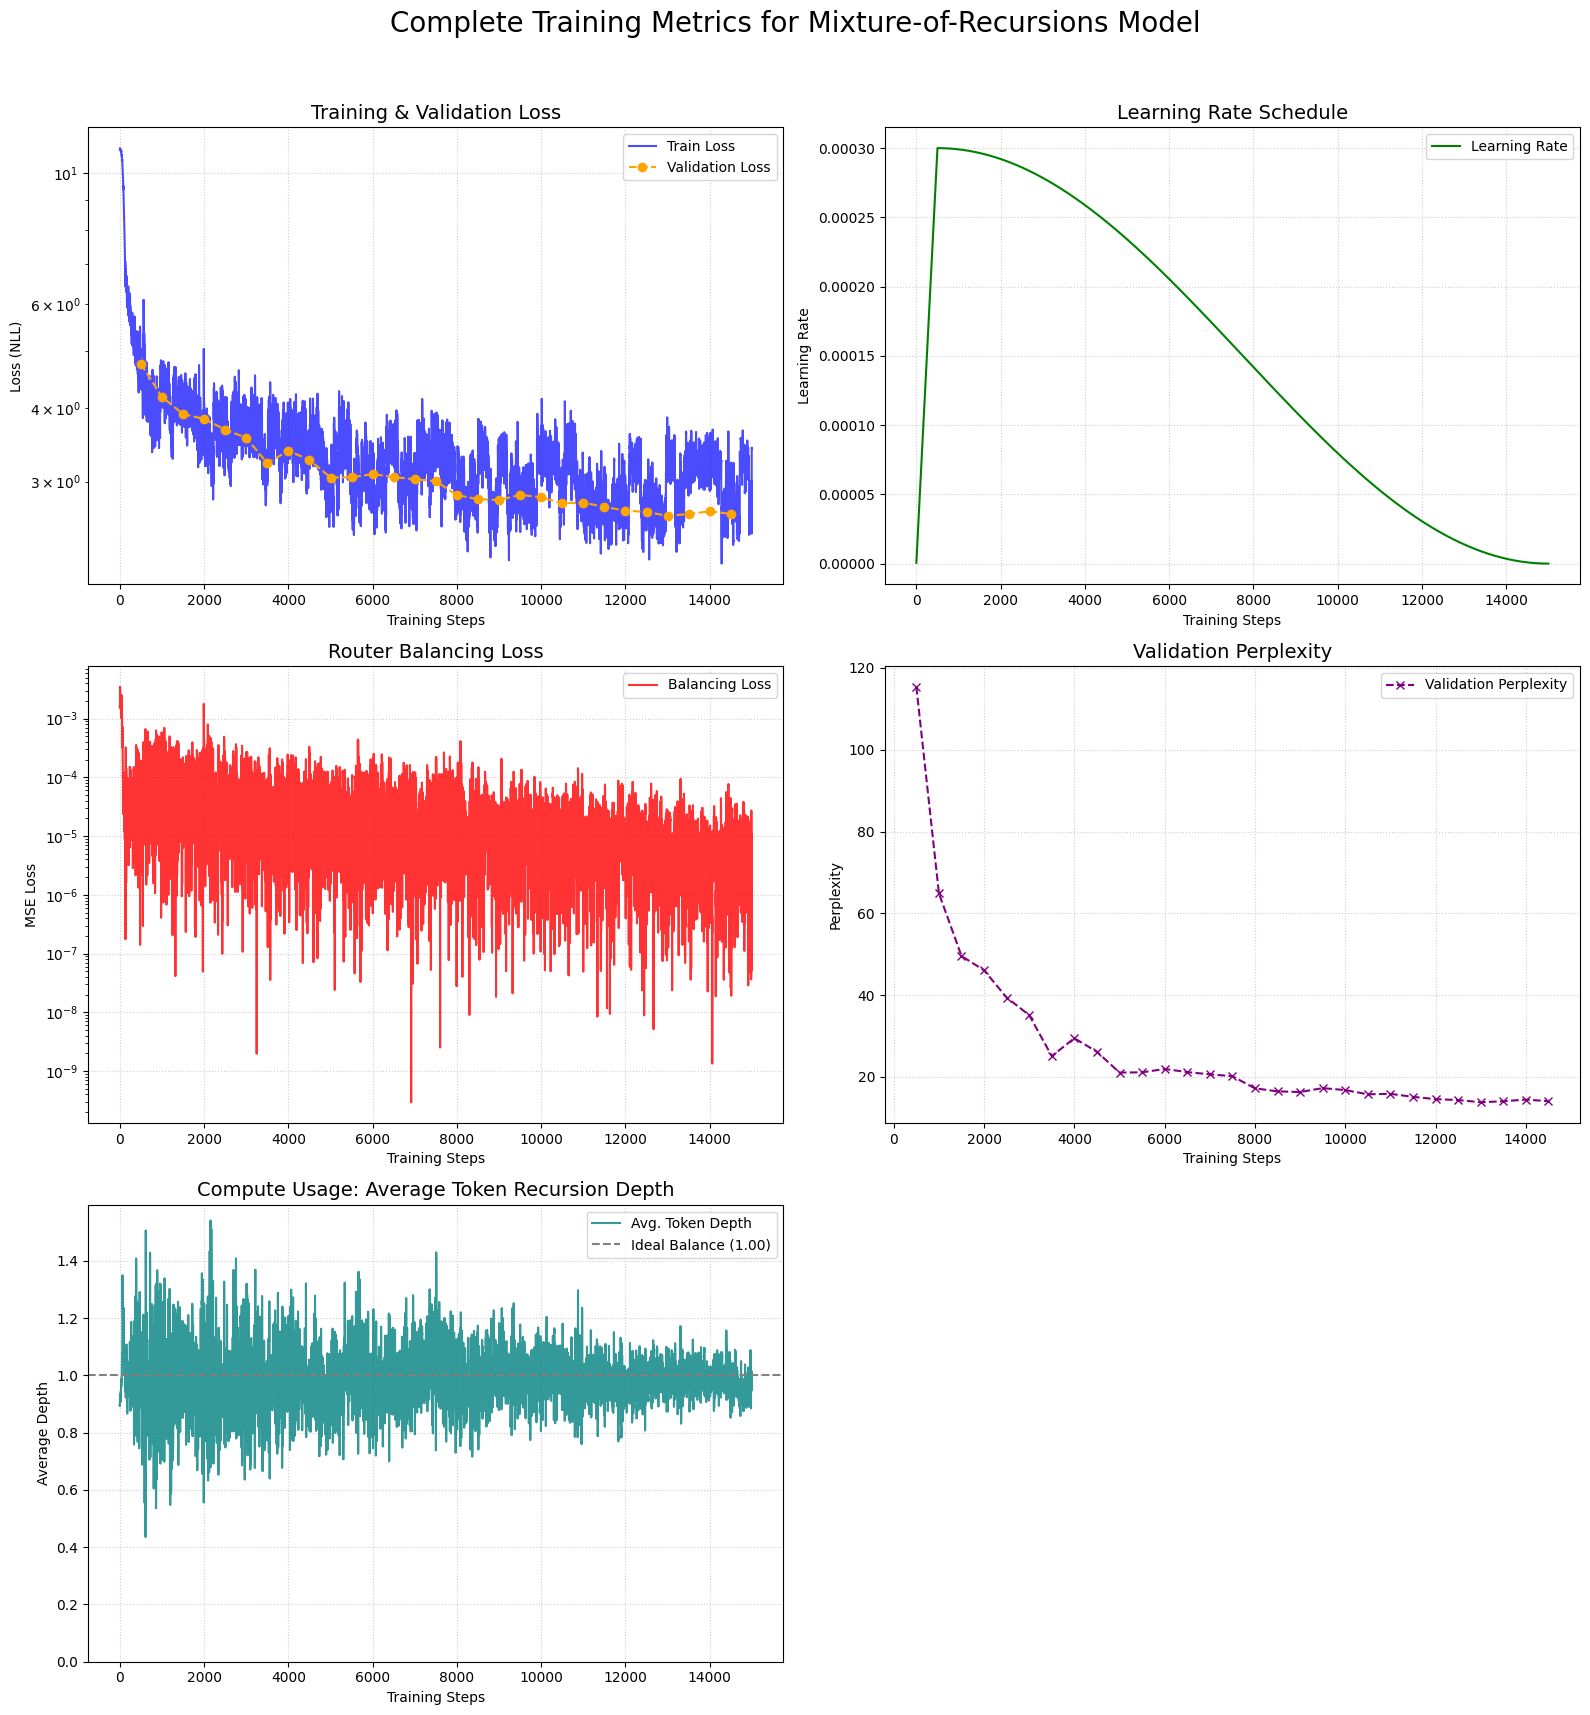

In [14]:
import json
import matplotlib.pyplot as plt
import torch

def load_logs(filename="training_logs.json"):
    """
    Safely loads the training logs from a JSON file.
    Handles the case where the file might not exist.
    """
    try:
        with open(filename, 'r') as f:
            logs = json.load(f)
        print(f"Logs successfully loaded from {filename}")
        return logs
    except FileNotFoundError:
        print(f"--- ERROR ---")
        print(f"Log file not found at '{filename}'.")
        print("Please make sure the JSON file is in the same directory or provide the correct path.")
        return None
    except json.JSONDecodeError:
        print(f"--- ERROR ---")
        print(f"Could not read '{filename}'. Please ensure it is a valid JSON file.")
        print("You may need to check for missing commas or brackets.")
        return None

def plot_final_metrics(logs):
    """
    Creates a comprehensive 3x2 grid of plots from a logs dictionary.
    This function is self-contained and does not depend on the model object.
    """
    if not logs:
        print("Cannot generate plots because no logs were loaded.")
        return

    fig, axs = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Complete Training Metrics for Mixture-of-Recursions Model', fontsize=20)

    ax1 = axs[0, 0]
    ax1.plot(logs['train_loss'], label='Train Loss', color='blue', alpha=0.7)
    if logs.get('val_loss'):
        val_steps, val_scores = zip(*logs['val_loss'])
        ax1.plot(val_steps, val_scores, label='Validation Loss', color='orange', marker='o', linestyle='--')
    ax1.set_title('Training & Validation Loss', fontsize=14)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss (NLL)')
    ax1.grid(True, linestyle=':', alpha=0.6)
    ax1.legend()
    ax1.set_yscale('log')

    ax2 = axs[0, 1]
    ax2.plot(logs['lr'], label='Learning Rate', color='green')
    ax2.set_title('Learning Rate Schedule', fontsize=14)
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Learning Rate')
    ax2.grid(True, linestyle=':', alpha=0.6)
    ax2.legend()

    ax3 = axs[1, 0]
    ax3.plot(logs['bal_loss'], label='Balancing Loss', color='red', alpha=0.8)
    ax3.set_title('Router Balancing Loss', fontsize=14)
    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('MSE Loss')
    ax3.grid(True, linestyle=':', alpha=0.6)
    ax3.legend()
    ax3.set_yscale('log')
    ax4 = axs[1, 1]
    if logs.get('val_loss'):
        val_steps, val_scores = zip(*logs['val_loss'])
        perplexities = [torch.exp(torch.tensor(s)).item() for s in val_scores]
        ax4.plot(val_steps, perplexities, label='Validation Perplexity', color='purple', marker='x', linestyle='--')
        ax4.set_title('Validation Perplexity', fontsize=14)
        ax4.set_xlabel('Training Steps')
        ax4.set_ylabel('Perplexity')
        ax4.grid(True, linestyle=':', alpha=0.6)
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'No validation data to plot Perplexity', ha='center', va='center')

    ax5 = axs[2, 0]
    if logs.get('avg_depth'):
        ax5.plot(logs['avg_depth'], label='Avg. Token Depth', color='teal', alpha=0.8)
        max_depth = logs.get("max_depth", 3)
        ideal_depth = sum(range(max_depth)) / max_depth # (0+1+2)/3 = 1.0
        ax5.axhline(y=ideal_depth, color='gray', linestyle='--', label=f'Ideal Balance ({ideal_depth:.2f})')
        ax5.set_title('Compute Usage: Average Token Recursion Depth', fontsize=14)
        ax5.set_xlabel('Training Steps')
        ax5.set_ylabel('Average Depth')
        ax5.grid(True, linestyle=':', alpha=0.6)
        ax5.legend()
        ax5.set_ylim(bottom=0) # Depth cannot be negative
    else:
        ax5.text(0.5, 0.5, 'No avg_depth data in logs', ha='center', va='center')

    axs[2, 1].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


if __name__ == "__main__":
    log_filename = "training_logs.json"

    my_logs = load_logs(log_filename)

    if my_logs:
        plot_final_metrics(my_logs)